In [118]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
import pandas as pd
from tqdm import tqdm

In [119]:
WINDOW_LENGTH = 256  # data window
STRIDE = 128  # stride
BATCH_SIZE = 128  # batch
EPOCHS = 100  # epoch
LEARNING_RATE = 0.001  # lr
PROJ_DIM = 128  # embedding dimension

HARD_NEGATIVE_FACTOR = 0.1
TEMPERATURE = 0.5

In [120]:
datapath = "../../../data/MobiFall_Dataset/" 

In [121]:
adl_activities = ['STD', 'WAL', 'JOG', 'JUM', 
                  'STU', 'STN', 'SCH', 'CSI', 'CSO'] 
fall_activities = ['FOL', 'FKL', 'BSC', 'SDL'] 

label2id = {act: 0 for act in adl_activities}
label2id.update({act: 1 for act in fall_activities})

In [122]:
adl_fall_subjects = list(range(1, 12))
print("ADL+Fall subjects:", adl_fall_subjects)

fall_only_subjects = list(range(12, 22)) + list(range(29, 32))
print("Fall-only subjects:", fall_only_subjects)

train_split = adl_fall_subjects[:8] + fall_only_subjects[:9]    
val_split = adl_fall_subjects[8:10] + fall_only_subjects[9:11]    
test_split = adl_fall_subjects[10:] + fall_only_subjects[11:]   

print(f"Train subjects (ADL+Fall): {adl_fall_subjects[:8]}")
print(f"Train subjects (Fall only): {fall_only_subjects[:9]}")
print(f"Total train subjects: {train_split}\n")

print(f"Val subjects (ADL+Fall): {adl_fall_subjects[8:10]}")
print(f"Val subjects (Fall only): {fall_only_subjects[9:11]}")
print(f"Total val subjects: {val_split}\n")

print(f"Test subjects (ADL+Fall): {adl_fall_subjects[10:]}")
print(f"Test subjects (Fall only): {fall_only_subjects[11:]}")
print(f"Total test subjects: {test_split}\n")

print(f"Total number of train subjects: {len(train_split)}")
print(f"Total number of validation subjects: {len(val_split)}")
print(f"Total number of test subjects: {len(test_split)}")

ADL+Fall subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Fall-only subjects: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29, 30, 31]
Train subjects (ADL+Fall): [1, 2, 3, 4, 5, 6, 7, 8]
Train subjects (Fall only): [12, 13, 14, 15, 16, 17, 18, 19, 20]
Total train subjects: [1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Val subjects (ADL+Fall): [9, 10]
Val subjects (Fall only): [21, 29]
Total val subjects: [9, 10, 21, 29]

Test subjects (ADL+Fall): [11]
Test subjects (Fall only): [30, 31]
Total test subjects: [11, 30, 31]

Total number of train subjects: 17
Total number of validation subjects: 4
Total number of test subjects: 3


In [123]:
def read_sensor_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        
        data_start = 0
        for i, line in enumerate(lines):
            if line.strip() == '@DATA' :  # data tag finding
                data_start = i + 1
                break
        
        ###### parsing part
        data_lines = []
        for line in lines[data_start:]:
            if line.strip():  
                try:
                    values = [float(val.strip()) for val in line.strip().split(',')]
                    if all(np.isfinite(values)) : # <-- if finite?
                        data_lines.append(values)
                except ValueError:
                    continue
        
        df = pd.DataFrame(data_lines) 
        df = df.fillna(0) # <-- nan -> 0
        return df

In [124]:
def split_sequences(data, labels, 
                    window_length=WINDOW_LENGTH, 
                    stride=STRIDE,
                    clean=True):
    idx = 0
    endidx = len(data)
    windows = []
    window_labels = []
    
    while idx < endidx - window_length:
        data_segment = data[idx:idx+window_length].T
        
        if clean and len(np.unique(labels[idx:idx + window_length])) > 1:
            pass
        else:
            windows.append(data_segment)
            window_labels.append(labels[idx+window_length])
        
        idx += stride
    
    if len(windows) == 0:
        return None, None
    
    return np.stack(windows), np.asarray(window_labels)

In [125]:
'''
    TRAIN DATA PREPARING PART
    ONLY "ADL"
'''

train_data_normal = []  
train_labels_normal = [] 

for subject_id in tqdm(train_split):
    if subject_id >= 12 :  
        # Fall-only -> SKIP at train data
        continue
        
    subject_dir = os.path.join(datapath, f"sub{subject_id}")
    adl_dir = os.path.join(subject_dir, "ADL")
        
    for activity in adl_activities : # ONLY ADL (normal first)
        activity_dir = os.path.join(adl_dir, activity)
            
        acc_pattern = f"{activity}_acc_{subject_id}_*.txt"
        acc_files = glob.glob(os.path.join(activity_dir, acc_pattern))
        
        for acc_file in acc_files:
            trial_num = acc_file.split('_')[-1]
            gyro_file = os.path.join(activity_dir, 
                                     f"{activity}_gyro_{subject_id}_{trial_num}")
                
            try:
                acc_data = read_sensor_file(acc_file)
                acc_data.columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z']
                
                gyro_data = read_sensor_file(gyro_file)
                gyro_data.columns = ['timestamp', 'gyro_x', 'gyro_y', 'gyro_z']
                
                merged_data = pd.merge_asof(
                    acc_data.sort_values('timestamp'),
                    gyro_data.sort_values('timestamp'),
                    on='timestamp',
                    direction='nearest',
                    tolerance=1e7
                )
                
                merged_data = merged_data.fillna(0)
                sensor_data = merged_data[['acc_x', 'acc_y', 'acc_z',
                                         'gyro_x', 'gyro_y', 'gyro_z']].values
                
                activity_labels = np.full(len(sensor_data), label2id[activity])
                
                windows_data, windows_labels = split_sequences(
                    sensor_data, activity_labels, 
                    WINDOW_LENGTH, STRIDE
                )
                
                if len(windows_data) > 0:
                    train_data_normal.append(windows_data)
                    train_labels_normal.append(windows_labels)
                    
            except : 
                print (error)
                
train_data_normal = np.concatenate(train_data_normal, axis=0)
train_labels_normal = np.concatenate(train_labels_normal)

print (f"# of windows: {len(train_data_normal)}")
print (f"data shape: {train_data_normal.shape}")
print (f"shape: {train_labels_normal.shape}")
unique_labels, counts = np.unique(train_labels_normal, return_counts=True)
print (dict(zip(unique_labels, counts)))

100%|███████████████████████████████████████████| 17/17 [00:12<00:00,  1.40it/s]

# of windows: 3842
data shape: (3842, 6, 256)
shape: (3842,)
{0: 3842}


In [126]:
'''
    TRAIN DATA PREPARING PART
    ADL + FALL
'''

test_data = []
test_labels = []

for subject_id in tqdm(test_split):
    subject_dir = os.path.join(datapath, f"sub{subject_id}")
    
    if subject_id < 12: # ADL
        adl_dir = os.path.join(subject_dir, "ADL")
        if os.path.exists(adl_dir):
            for activity in adl_activities:
                activity_dir = os.path.join(adl_dir, activity)
                if not os.path.exists(activity_dir):
                    continue

                acc_pattern = f"{activity}_acc_{subject_id}_*.txt"
                acc_files = glob.glob(os.path.join(activity_dir, acc_pattern))
                
                for acc_file in acc_files:
                    trial_num = acc_file.split('_')[-1]
                    gyro_file = os.path.join(activity_dir, f"{activity}_gyro_{subject_id}_{trial_num}")
                    
                    if not os.path.exists(gyro_file):
                        continue
                        
                    try:
                        acc_data = read_sensor_file(acc_file)
                        acc_data.columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z']
                        
                        gyro_data = read_sensor_file(gyro_file)
                        gyro_data.columns = ['timestamp', 'gyro_x', 'gyro_y', 'gyro_z']
                        
                        merged_data = pd.merge_asof(
                            acc_data.sort_values('timestamp'),
                            gyro_data.sort_values('timestamp'),
                            on='timestamp',
                            direction='nearest',
                            tolerance=1e7
                        )
                        
                        merged_data = merged_data.fillna(0)
                        sensor_data = merged_data[['acc_x', 'acc_y', 'acc_z',
                                                 'gyro_x', 'gyro_y', 'gyro_z']].values
                        
                        activity_labels = np.full(len(sensor_data), label2id[activity])
                        windows_data, windows_labels = split_sequences(sensor_data, activity_labels)
                        
                        if len(windows_data) > 0:
                            test_data.append(windows_data)
                            test_labels.append(windows_labels)
                            
                    except : 
                        print("error")
                            
    
    falls_dir = os.path.join(subject_dir, "FALLS") # FALL (all subjects)
    if os.path.exists(falls_dir):
        for activity in fall_activities:
            activity_dir = os.path.join(falls_dir, activity)
            if not os.path.exists(activity_dir):
                continue
                
            acc_pattern = f"{activity}_acc_{subject_id}_*.txt"
            acc_files = glob.glob(os.path.join(activity_dir, acc_pattern))
            
            for acc_file in acc_files:
                trial_num = acc_file.split('_')[-1]
                gyro_file = os.path.join(activity_dir, f"{activity}_gyro_{subject_id}_{trial_num}")
                
                if not os.path.exists(gyro_file):
                    continue
                    
                try:
                    acc_data = read_sensor_file(acc_file)
                    acc_data.columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z']
                    
                    gyro_data = read_sensor_file(gyro_file)
                    gyro_data.columns = ['timestamp', 'gyro_x', 'gyro_y', 'gyro_z']
                    
                    merged_data = pd.merge_asof(
                        acc_data.sort_values('timestamp'),
                        gyro_data.sort_values('timestamp'),
                        on='timestamp',
                        direction='nearest',
                        tolerance=1e7
                    )
                    
                    merged_data = merged_data.fillna(0)
                    sensor_data = merged_data[['acc_x', 'acc_y', 'acc_z',
                                             'gyro_x', 'gyro_y', 'gyro_z']].values
                    
                    activity_labels = np.full(len(sensor_data), label2id[activity])
                    windows_data, windows_labels = split_sequences(sensor_data, activity_labels)
                    
                    if len(windows_data) > 0:
                        test_data.append(windows_data)
                        test_labels.append(windows_labels)
                        
                except : 
                    print ('error')

test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels)

print(f"# of windows: {len(test_data)}")
print(f"data shape: {test_data.shape}")
print(f"shape: {test_labels.shape}")
unique_labels, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique_labels, counts)))

100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]

# of windows: 813
data shape: (813, 6, 256)
shape: (813,)
{0: 634, 1: 179}


In [127]:
train_acc_normal = train_data_normal[..., :3] 
train_gyro_normal = train_data_normal[..., 3:]  
# (x, y, z)

test_acc = test_data[..., :3]  
test_gyro = test_data[..., 3:] 

# train : ONLY NORMAL
train_dataset = tf.data.Dataset.from_tensor_slices((train_acc_normal, train_gyro_normal))
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ((test_acc, test_gyro), test_labels)
).batch(BATCH_SIZE)

print (f"train data - accel shape: {train_acc_normal.shape}")
print (f"train data - gyro shape: {train_gyro_normal.shape}")
print (f"test data - accel shape: {test_acc.shape}")
print (f"test data - gyro shape: {test_gyro.shape}")
print (f"# of training batches: {len(train_dataset)}")
print (f"# of test batches: {len(test_dataset)}")

train data - accel shape: (3842, 6, 3)
train data - gyro shape: (3842, 6, 253)
test data - accel shape: (813, 6, 3)
test data - gyro shape: (813, 6, 253)
# of training batches: 31
# of test batches: 7


------

In [128]:
class DefaultEncoder(Model):
    def __init__(self, in_feat, out_feat, num_encoders=1, use_skip=True):
        super(DefaultEncoder, self).__init__()
        self.conv1 = layers.Conv1D(512, 8, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv1D(256, 5, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv1D(128, 3, padding='same')
        self.gap = layers.GlobalAveragePooling1D()
        
    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = tf.nn.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.leaky_relu(x)
        x = self.conv3(x)
        return self.gap(x)

# 사용 예시
test_input = tf.random.normal([2, WINDOW_LENGTH, 3])
encoder = DefaultEncoder(in_feat=3, out_feat=64, num_encoders=2, use_skip=True)
test_output = encoder(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print ("encoder success!")

Input shape: (2, 256, 3)
Output shape: (2, 128)
encoder success!


In [129]:
class CAGE(Model):
    def __init__(self, n_feat=6, proj_dim=128):
        super(CAGE, self).__init__()
        self.proj_dim = proj_dim
        
        self.enc_A = DefaultEncoder(n_feat, 64,
                                   num_encoders=2,
                                   use_skip=True)  # for accel
        self.enc_G = DefaultEncoder(n_feat, 64,
                                   num_encoders=2,
                                   use_skip=True)  # for gyro
        
        if self.proj_dim > 0 :
            self.proj_A = layers.Dense(proj_dim, 
                                       use_bias=False)
            self.proj_G = layers.Dense(proj_dim, 
                                       use_bias=False)
            
            self.bn_A = layers.BatchNormalization()
            self.bn_G = layers.BatchNormalization()
        
        self.temperature = tf.Variable(0.5, trainable=True)
    
    def call(self, x_accel, x_gyro, return_feat=False, training=False):
        f_accel = self.enc_A(x_accel, training=training)
        f_gyro = self.enc_G(x_gyro, training=training)
        
        if self.proj_dim > 0:
            e_accel = self.proj_A(f_accel)
            e_gyro = self.proj_G(f_gyro)
            
            if training:
                e_accel = self.bn_A(e_accel, training=training)
                e_gyro = self.bn_G(e_gyro, training=training)

        else:
            e_accel = f_accel
            e_gyro = f_gyro
        
        e_accel = tf.math.l2_normalize(e_accel, axis=1)
        e_gyro = tf.math.l2_normalize(e_gyro, axis=1)
        
        logits = tf.matmul(e_accel, e_gyro, transpose_b=True) / self.temperature
        
        if return_feat:
            return logits, (f_accel, f_gyro)
        
        return logits

#### below : test CAGE architecture

test_accel = tf.random.normal([2, WINDOW_LENGTH, 3])
test_gyro = tf.random.normal([2, WINDOW_LENGTH, 3])
model = CAGE(n_feat=3, proj_dim=128)
test_logits = model(test_accel, test_gyro)

print (f"accel input shape : {test_accel.shape}")
print (f"gyro input shape : {test_gyro.shape}")
print (f"output shape: {test_logits.shape}")
print ("unsupervised_CAGE success!")

accel input shape : (2, 256, 3)
gyro input shape : (2, 256, 3)
output shape: (2, 2)
unsupervised_CAGE success!


In [130]:
model = CAGE(proj_dim=PROJ_DIM)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE
)

In [131]:
# @tf.function
# def contrastive_loss(logits):
#     """NT-Xent Loss"""
#     batch_size = tf.shape(logits)[0]
    
#     labels = tf.eye(batch_size) # diagonal matrix 
    
#     '''
#         loss calculating using CrossEntropy
#     '''
#     loss = tf.keras.losses.categorical_crossentropy(
#         labels, 
#         tf.nn.softmax(logits, axis=-1), 
#         from_logits=False
#     )
    
#     return tf.reduce_mean(loss)

@tf.function
def contrastive_loss(logits, temperature=0.1):
    batch_size = tf.shape(logits)[0]
    
    # 수치 안정성을 위한 로그-섬-지수 트릭 적용
    logits = logits / temperature
    logits = logits - tf.reduce_max(logits, axis=1, keepdims=True)  # 수치 안정성
    exp_logits = tf.exp(logits)
    
    # Positive pair는 대각선
    positive_mask = tf.eye(batch_size)
    denominator = tf.reduce_sum(exp_logits, axis=1)
    
    # 안정적인 log 연산
    log_prob = logits - tf.math.log(denominator + 1e-6)
    
    # InfoNCE loss 계산
    loss = tf.reduce_mean(-tf.reduce_sum(positive_mask * log_prob, axis=1))
    
    return loss

In [132]:
@tf.function
def train_step(model, optimizer, x_accel, x_gyro):
    with tf.GradientTape() as tape:
        ssl_output, (f_accel, f_gyro) = model(x_accel, x_gyro, return_feat=True, training=True)
        
        # loss 계산을 scalar 값으로 확실히 만듦
        batch_loss = contrastive_loss(ssl_output)
        batch_loss = tf.reduce_mean(batch_loss)  # 배치에 대한 평균을 명시적으로 계산
        
        # loss가 유한한 값인지 확인
        batch_loss = tf.where(tf.math.is_finite(batch_loss), batch_loss, 0.0)

    gradients = tape.gradient(batch_loss, model.trainable_variables)
    gradients = [
        tf.clip_by_norm(g, 1.0) if g is not None else g 
        for g in gradients
    ]
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return batch_loss, ssl_output

----

In [133]:
print (train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 6, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6, 253), dtype=tf.float64, name=None))>


In [134]:
train_losses = []
best_loss = float('inf')

for epoch in range(EPOCHS):
    epoch_losses = []
    
    for acc_batch, gyro_batch in tqdm(train_dataset, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        loss, _ = train_step(model, optimizer, acc_batch, gyro_batch)
        # loss를 numpy 스칼라 값으로 변환
        epoch_losses.append(float(loss.numpy()))
    
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    
    print(f"Epoch {epoch + 1}, Mean Loss: {avg_loss:.4f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        print(f"New best loss achieved: {best_loss:.4f}")

print ("END THE LEARNING")
print (f"final best loss: {best_loss:.4f}")

Epoch 1/100: 100%|██████████████████████████████| 31/31 [00:08<00:00,  3.48it/s]


Epoch 1, Mean Loss: 4.9050
New best loss achieved: 4.9050


Epoch 2/100: 100%|██████████████████████████████| 31/31 [00:03<00:00,  7.82it/s]


Epoch 2, Mean Loss: 4.1225
New best loss achieved: 4.1225


Epoch 3/100: 100%|██████████████████████████████| 31/31 [00:04<00:00,  6.24it/s]


Epoch 3, Mean Loss: 3.7304
New best loss achieved: 3.7304


Epoch 4/100: 100%|██████████████████████████████| 31/31 [00:04<00:00,  6.81it/s]


Epoch 4, Mean Loss: 3.4116
New best loss achieved: 3.4116


Epoch 5/100: 100%|██████████████████████████████| 31/31 [00:04<00:00,  6.99it/s]


Epoch 5, Mean Loss: 3.1099
New best loss achieved: 3.1099


Epoch 6/100: 100%|██████████████████████████████| 31/31 [00:03<00:00,  8.03it/s]


Epoch 6, Mean Loss: 2.9219
New best loss achieved: 2.9219


Epoch 7/100: 100%|██████████████████████████████| 31/31 [00:03<00:00,  8.20it/s]


Epoch 7, Mean Loss: 2.7676
New best loss achieved: 2.7676


Epoch 8/100: 100%|██████████████████████████████| 31/31 [00:03<00:00,  7.82it/s]


Epoch 8, Mean Loss: 2.6212
New best loss achieved: 2.6212


Epoch 9/100: 100%|██████████████████████████████| 31/31 [00:03<00:00,  8.04it/s]


Epoch 9, Mean Loss: 2.4528
New best loss achieved: 2.4528


Epoch 10/100: 100%|█████████████████████████████| 31/31 [00:03<00:00,  7.78it/s]


Epoch 10, Mean Loss: 2.3445
New best loss achieved: 2.3445


Epoch 11/100: 100%|█████████████████████████████| 31/31 [00:03<00:00,  7.94it/s]


Epoch 11, Mean Loss: 2.3234
New best loss achieved: 2.3234


Epoch 12/100: 100%|█████████████████████████████| 31/31 [00:03<00:00,  8.55it/s]


Epoch 12, Mean Loss: 2.2017
New best loss achieved: 2.2017


Epoch 13/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.72it/s]


Epoch 13, Mean Loss: 2.2142


Epoch 14/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.66it/s]


Epoch 14, Mean Loss: 2.0162
New best loss achieved: 2.0162


Epoch 15/100: 100%|█████████████████████████████| 31/31 [00:03<00:00,  7.95it/s]


Epoch 15, Mean Loss: 1.9480
New best loss achieved: 1.9480


Epoch 16/100: 100%|█████████████████████████████| 31/31 [00:03<00:00,  8.00it/s]


Epoch 16, Mean Loss: 1.9370
New best loss achieved: 1.9370


Epoch 17/100: 100%|█████████████████████████████| 31/31 [00:03<00:00,  7.86it/s]


Epoch 17, Mean Loss: 1.8401
New best loss achieved: 1.8401


Epoch 18/100: 100%|█████████████████████████████| 31/31 [00:05<00:00,  5.79it/s]


Epoch 18, Mean Loss: 1.9046


Epoch 19/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.42it/s]


Epoch 19, Mean Loss: 1.7988
New best loss achieved: 1.7988


Epoch 20/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.73it/s]


Epoch 20, Mean Loss: 1.7521
New best loss achieved: 1.7521


Epoch 21/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.27it/s]


Epoch 21, Mean Loss: 1.7643


Epoch 22/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.74it/s]


Epoch 22, Mean Loss: 1.6847
New best loss achieved: 1.6847


Epoch 23/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.72it/s]


Epoch 23, Mean Loss: 1.6814
New best loss achieved: 1.6814


Epoch 24/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.69it/s]


Epoch 24, Mean Loss: 1.5847
New best loss achieved: 1.5847


Epoch 25/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.68it/s]


Epoch 25, Mean Loss: 1.5170
New best loss achieved: 1.5170


Epoch 26/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.56it/s]


Epoch 26, Mean Loss: 1.5406


Epoch 27/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.69it/s]


Epoch 27, Mean Loss: 1.5864


Epoch 28/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.52it/s]


Epoch 28, Mean Loss: 1.4983
New best loss achieved: 1.4983


Epoch 29/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.56it/s]


Epoch 29, Mean Loss: 1.4224
New best loss achieved: 1.4224


Epoch 30/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.94it/s]


Epoch 30, Mean Loss: 1.4844


Epoch 31/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.72it/s]


Epoch 31, Mean Loss: 1.5011


Epoch 32/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.51it/s]


Epoch 32, Mean Loss: 1.3950
New best loss achieved: 1.3950


Epoch 33/100: 100%|█████████████████████████████| 31/31 [00:05<00:00,  6.19it/s]


Epoch 33, Mean Loss: 1.4542


Epoch 34/100: 100%|█████████████████████████████| 31/31 [00:05<00:00,  6.16it/s]


Epoch 34, Mean Loss: 1.3810
New best loss achieved: 1.3810


Epoch 35/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.96it/s]


Epoch 35, Mean Loss: 1.3278
New best loss achieved: 1.3278


Epoch 36/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.48it/s]


Epoch 36, Mean Loss: 1.2779
New best loss achieved: 1.2779


Epoch 37/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.45it/s]


Epoch 37, Mean Loss: 1.2589
New best loss achieved: 1.2589


Epoch 38/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.86it/s]


Epoch 38, Mean Loss: 1.3053


Epoch 39/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.30it/s]


Epoch 39, Mean Loss: 1.2546
New best loss achieved: 1.2546


Epoch 40/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.53it/s]


Epoch 40, Mean Loss: 1.3479


Epoch 41/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.36it/s]


Epoch 41, Mean Loss: 1.3028


Epoch 42/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.58it/s]


Epoch 42, Mean Loss: 1.2480
New best loss achieved: 1.2480


Epoch 43/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.93it/s]


Epoch 43, Mean Loss: 1.2229
New best loss achieved: 1.2229


Epoch 44/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.00it/s]


Epoch 44, Mean Loss: 1.1614
New best loss achieved: 1.1614


Epoch 45/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.39it/s]


Epoch 45, Mean Loss: 1.2059


Epoch 46/100: 100%|█████████████████████████████| 31/31 [00:05<00:00,  6.16it/s]


Epoch 46, Mean Loss: 1.1686


Epoch 47/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.05it/s]


Epoch 47, Mean Loss: 1.1232
New best loss achieved: 1.1232


Epoch 48/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.62it/s]


Epoch 48, Mean Loss: 1.1946


Epoch 49/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.88it/s]


Epoch 49, Mean Loss: 1.1461


Epoch 50/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.76it/s]


Epoch 50, Mean Loss: 1.0942
New best loss achieved: 1.0942


Epoch 51/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.09it/s]


Epoch 51, Mean Loss: 1.1365


Epoch 52/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.71it/s]


Epoch 52, Mean Loss: 0.9993
New best loss achieved: 0.9993


Epoch 53/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.60it/s]


Epoch 53, Mean Loss: 1.0769


Epoch 54/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.52it/s]


Epoch 54, Mean Loss: 1.1056


Epoch 55/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.28it/s]


Epoch 55, Mean Loss: 1.0560


Epoch 56/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.48it/s]


Epoch 56, Mean Loss: 1.0926


Epoch 57/100: 100%|█████████████████████████████| 31/31 [00:05<00:00,  6.18it/s]


Epoch 57, Mean Loss: 1.0499


Epoch 58/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.98it/s]


Epoch 58, Mean Loss: 1.0585


Epoch 59/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.59it/s]


Epoch 59, Mean Loss: 1.1220


Epoch 60/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.40it/s]


Epoch 60, Mean Loss: 1.0501


Epoch 61/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.54it/s]


Epoch 61, Mean Loss: 1.0550


Epoch 62/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.18it/s]


Epoch 62, Mean Loss: 0.9970
New best loss achieved: 0.9970


Epoch 63/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.81it/s]


Epoch 63, Mean Loss: 1.1408


Epoch 64/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.16it/s]


Epoch 64, Mean Loss: 1.0060


Epoch 65/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.61it/s]


Epoch 65, Mean Loss: 1.0010


Epoch 66/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.96it/s]


Epoch 66, Mean Loss: 0.9767
New best loss achieved: 0.9767


Epoch 67/100: 100%|█████████████████████████████| 31/31 [00:05<00:00,  6.18it/s]


Epoch 67, Mean Loss: 1.0359


Epoch 68/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.20it/s]


Epoch 68, Mean Loss: 1.0090


Epoch 69/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.54it/s]


Epoch 69, Mean Loss: 0.8930
New best loss achieved: 0.8930


Epoch 70/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.73it/s]


Epoch 70, Mean Loss: 0.9297


Epoch 71/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.88it/s]


Epoch 71, Mean Loss: 0.9802


Epoch 72/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.47it/s]


Epoch 72, Mean Loss: 0.8589
New best loss achieved: 0.8589


Epoch 73/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.65it/s]


Epoch 73, Mean Loss: 0.9798


Epoch 74/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.07it/s]


Epoch 74, Mean Loss: 0.9025


Epoch 75/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.53it/s]


Epoch 75, Mean Loss: 0.9307


Epoch 76/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.27it/s]


Epoch 76, Mean Loss: 1.0000


Epoch 77/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.41it/s]


Epoch 77, Mean Loss: 0.9745


Epoch 78/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.24it/s]


Epoch 78, Mean Loss: 0.9310


Epoch 79/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.21it/s]


Epoch 79, Mean Loss: 0.7836
New best loss achieved: 0.7836


Epoch 80/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.59it/s]


Epoch 80, Mean Loss: 0.8706


Epoch 81/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.82it/s]


Epoch 81, Mean Loss: 0.9948


Epoch 82/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.65it/s]


Epoch 82, Mean Loss: 0.8832


Epoch 83/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.70it/s]


Epoch 83, Mean Loss: 0.9267


Epoch 84/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.56it/s]


Epoch 84, Mean Loss: 0.8829


Epoch 85/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.88it/s]


Epoch 85, Mean Loss: 0.7751
New best loss achieved: 0.7751


Epoch 86/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.65it/s]


Epoch 86, Mean Loss: 0.9087


Epoch 87/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.95it/s]


Epoch 87, Mean Loss: 0.8927


Epoch 88/100: 100%|█████████████████████████████| 31/31 [00:05<00:00,  6.14it/s]


Epoch 88, Mean Loss: 0.8943


Epoch 89/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.33it/s]


Epoch 89, Mean Loss: 0.8282


Epoch 90/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.17it/s]


Epoch 90, Mean Loss: 0.8438


Epoch 91/100: 100%|█████████████████████████████| 31/31 [00:05<00:00,  5.87it/s]


Epoch 91, Mean Loss: 0.8244


Epoch 92/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.76it/s]


Epoch 92, Mean Loss: 0.8791


Epoch 93/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.53it/s]


Epoch 93, Mean Loss: 0.8598


Epoch 94/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.11it/s]


Epoch 94, Mean Loss: 0.9082


Epoch 95/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.39it/s]


Epoch 95, Mean Loss: 0.8116


Epoch 96/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.32it/s]


Epoch 96, Mean Loss: 0.7599
New best loss achieved: 0.7599


Epoch 97/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.06it/s]


Epoch 97, Mean Loss: 0.8143


Epoch 98/100: 100%|█████████████████████████████| 31/31 [00:05<00:00,  6.14it/s]


Epoch 98, Mean Loss: 0.8941


Epoch 99/100: 100%|█████████████████████████████| 31/31 [00:04<00:00,  6.52it/s]


Epoch 99, Mean Loss: 0.8664


Epoch 100/100: 100%|████████████████████████████| 31/31 [00:04<00:00,  6.21it/s]

Epoch 100, Mean Loss: 0.7947
END THE LEARNING
final best loss: 0.7599


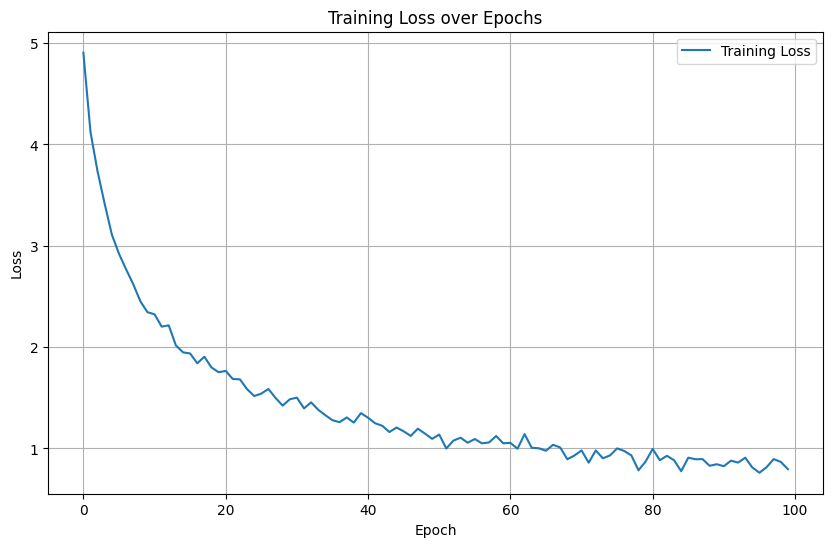

In [135]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [136]:
normal_similarities = []
for acc_batch, gyro_batch in tqdm(train_dataset, 
                                  desc='Computing normal similarities'):
    logits = model(acc_batch, gyro_batch, training=False)
    sim = tf.nn.softmax(logits, axis=-1)
    batch_similarities = tf.reduce_mean(sim, axis=1)
    normal_similarities.extend(batch_similarities.numpy())

test_similarities = []
test_pred_labels = []
for (acc_batch, gyro_batch), labels in tqdm(test_dataset, 
                                            desc='Computing test similarities'):
    logits = model(acc_batch, gyro_batch, training=False)
    sim = tf.nn.softmax(logits, axis=-1)
    batch_similarities = tf.reduce_mean(sim, axis=1)
    test_similarities.extend(batch_similarities.numpy())
    test_pred_labels.extend(labels.numpy())

Computing test similarities: 100%|████████████████| 7/7 [00:00<00:00, 10.71it/s]


In [137]:
threshold = np.percentile(normal_similarities, 5)

# def robust_threshold(similarities, method='gaussian_mixture'):
#     from sklearn.mixture import GaussianMixture
#     X = np.array(similarities).reshape(-1, 1)
    
#     # 가우시안 혼합 모델 사용
#     gmm = GaussianMixture(n_components=2, random_state=42)
#     gmm.fit(X)
    
#     # 클러스터 중심점 사이의 최적 임계값
#     means = gmm.means_.flatten()
#     stds = np.sqrt(gmm.covariances_.flatten())
    
#     # 두 클러스터 경계 계산
#     threshold = np.mean(means)
#     return threshold

# threshold = robust_threshold(normal_similarities, 
#                              method='dbscan')

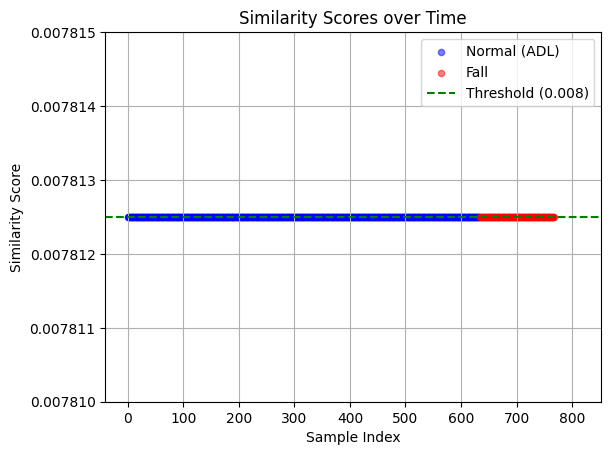

In [138]:
indices = range(len(test_similarities))
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 0], 
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 0],
           c='blue', label='Normal (ADL)', alpha=0.5, s=20)
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 1],
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 1],
           c='red', label='Fall', alpha=0.5, s=20)
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.3f})')
plt.ylim(0.0078100, 0.0078150)
plt.xlabel('Sample Index')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores over Time')
plt.legend()
plt.grid(True)

In [139]:
from sklearn.metrics import confusion_matrix, classification_report

predictions = [1 if sim < threshold else 0 for sim in test_similarities] 
true_labels = test_pred_labels

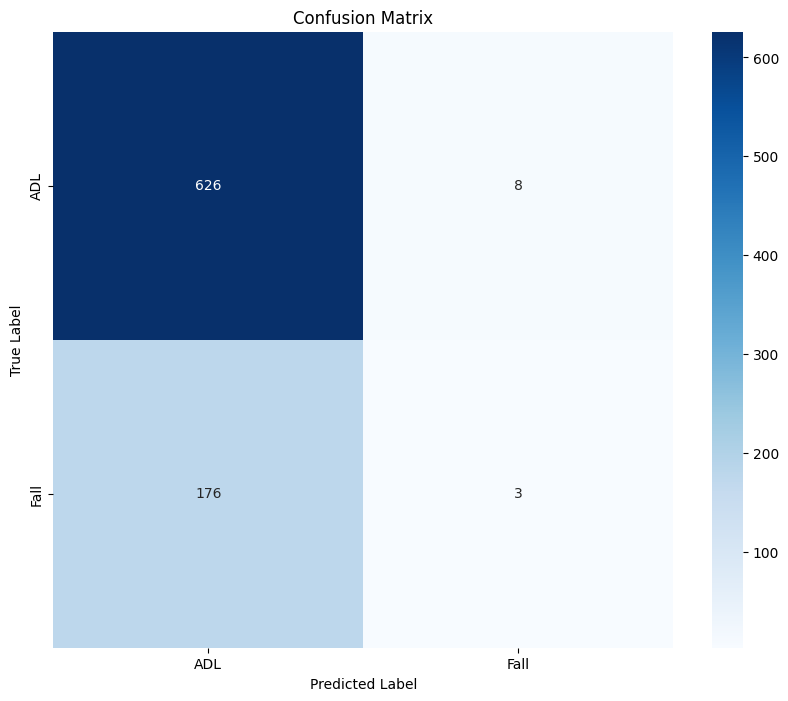

In [140]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
labels = ['ADL', 'Fall']
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)
plt.show()

In [141]:
print ("classification report")
print(classification_report(true_labels, predictions, 
                          target_names=['ADL', 'Fall']))

classification report
              precision    recall  f1-score   support

         ADL       0.78      0.99      0.87       634
        Fall       0.27      0.02      0.03       179

    accuracy                           0.77       813
   macro avg       0.53      0.50      0.45       813
weighted avg       0.67      0.77      0.69       813



In [142]:
def calculate_similarities(model, test_dataset):
    normal_similarities = []
    fall_similarities = []
    
    for (acc_batch, gyro_batch), labels in test_dataset:
        logits = model(acc_batch, gyro_batch, training=False)
        sim = tf.nn.softmax(logits, axis=-1)
        batch_similarities = tf.reduce_mean(sim, axis=1)
        
        for sim_score, label in zip(batch_similarities.numpy(), labels.numpy()):
            if label == 0:  # normal
                normal_similarities.append(sim_score)
            else:  # fall
                fall_similarities.append(sim_score)
    
    return np.array(normal_similarities), np.array(fall_similarities)

normal_sims, fall_sims = calculate_similarities(model, test_dataset)

print("[ ADL data ]")
print(f"  Mean: {np.mean(normal_sims):.4f}")
print(f"  Std: {np.std(normal_sims):.4f}")
print(f"  Min: {np.min(normal_sims):.4f}")
print(f"  Max: {np.max(normal_sims):.4f}")
for i in range (20) :
    print ('ADL ind', i+1, ':', normal_sims[i])

print ()
print("[ FALL data ]")
print(f"  Mean: {np.mean(fall_sims):.4f}")
print(f"  Std: {np.std(fall_sims):.4f}")
print(f"  Min: {np.min(fall_sims):.4f}")
print(f"  Max: {np.max(fall_sims):.4f}")
for i in range (20) :
    print ('FALL ind', i+1, ':', fall_sims[i])

[ ADL data ]
  Mean: 0.0078
  Std: 0.0000
  Min: 0.0078
  Max: 0.0078
ADL ind 1 : 0.0078125
ADL ind 2 : 0.0078125
ADL ind 3 : 0.0078125
ADL ind 4 : 0.0078125
ADL ind 5 : 0.0078125
ADL ind 6 : 0.0078124995
ADL ind 7 : 0.0078125
ADL ind 8 : 0.0078124995
ADL ind 9 : 0.0078124995
ADL ind 10 : 0.0078125
ADL ind 11 : 0.0078124995
ADL ind 12 : 0.0078125
ADL ind 13 : 0.0078125
ADL ind 14 : 0.007812499
ADL ind 15 : 0.007812499
ADL ind 16 : 0.0078124995
ADL ind 17 : 0.0078125
ADL ind 18 : 0.0078125
ADL ind 19 : 0.007812501
ADL ind 20 : 0.007812499

[ FALL data ]
  Mean: 0.0114
  Std: 0.0063
  Min: 0.0078
  Max: 0.0222
FALL ind 1 : 0.007812499
FALL ind 2 : 0.0078125
FALL ind 3 : 0.0078125
FALL ind 4 : 0.0078125
FALL ind 5 : 0.0078125
FALL ind 6 : 0.0078125
FALL ind 7 : 0.0078124986
FALL ind 8 : 0.007812499
FALL ind 9 : 0.0078125
FALL ind 10 : 0.0078125
FALL ind 11 : 0.0078125
FALL ind 12 : 0.0078125
FALL ind 13 : 0.007812499
FALL ind 14 : 0.0078125
FALL ind 15 : 0.007812499
FALL ind 16 : 0.007812